In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
import time
import numpy as np

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
#Arregla un bug donde marca un error con CUDA
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
!cat /usr/local/cuda/version.txt

CUDA Version 10.1.243


In [4]:
tf.__version__

'2.3.0'

## Loading the model for CPU

In [5]:
#saved_model_loaded = tf.saved_model.load('saved_model_tensorrt_production/my_model')
saved_model_loaded = tf.saved_model.load('saved_model_segunda_version_dos_anchors/my_model')

In [6]:
infer = saved_model_loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'output_1': TensorSpec(shape=(None, 40, 4), dtype=tf.float32, name='output_1')}


In [7]:
#labeling = infer(tf.constant(img))#labeling = infer(tf.constant(img))#labeling = infer(tf.constant(img))#labeling = infer(tf.constant(img))#labeling = infer(tf.constant(img))#labeling = infer(tf.constant(img)

## Testing inference time in i7 9700k

In [8]:
file = tf.keras.utils.get_file(
    "persons.jpg",
    "https://www.saltwire.com/media/photologue/photos/cache/STJ-A01-28102019-RawlinsCrossPedestrians3_large.jpg")

In [9]:
image = file
img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
_,height,width,_ =img.shape
img = tf.image.resize(img, (416, 416))/255

In [10]:
def preprocess(file_name):
    tf.image.decode_image(open(file_name, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img_input = tf.image.resize(img, (416, 416))/255
    
    return img_input

In [11]:
%timeit preprocess("pedestrians.jpg")

22.5 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit outputs = infer(tf.constant(img))

3.52 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
tiempo = []

for i in range(1000):
    a = time.time()
    _ = infer(tf.constant(img))
    b = time.time()
    tiempo.append(b-a)
    
print(1/np.mean(tiempo))

226.5834789938737


In [14]:
from scipy.stats import trim_mean
(1/trim_mean(tiempo,0.01))

227.4347202840133

In [15]:
np.mean(tiempo)

0.004413384437561035

In [16]:
trim_mean(tiempo,0.01)

0.0043968660490853444

(array([125., 226., 272., 186.,  77.,  46.,  43.,  20.,   3.,   2.]),
 array([0.00282383, 0.00339217, 0.00396051, 0.00452886, 0.0050972 ,
        0.00566554, 0.00623388, 0.00680223, 0.00737057, 0.00793891,
        0.00850725]),
 <BarContainer object of 10 artists>)

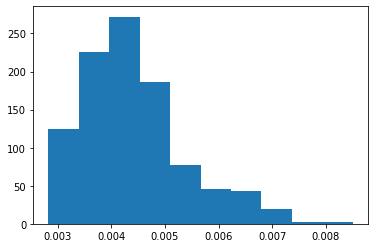

In [17]:
import matplotlib.pyplot as plt
plt.hist(tiempo,bins=10)

In [18]:
tiempo = []
with tf.device("CPU:0"):
    for i in range(200):
        inicio = time.time()
        _ = infer(tf.constant(img))
        fin = time.time()
        tiempo.append(fin-inicio)
print(1/np.mean(tiempo))

44.45183723858155


In [19]:
(1/trim_mean(tiempo,0.01))

45.67538040612063